In [3]:
import geoai
import os
import leafmap
import torch

In [5]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("cool")

cool


In [2]:
collections = geoai.pc_collection_list()
collections

Retrieved 126 collections from Planetary Computer


,id,title,description
42,3dep-lidar-classification,USGS 3DEP Lidar Classification,This collection is derived from the [USGS 3DEP...
28,3dep-lidar-copc,USGS 3DEP Lidar Point Cloud,This collection contains source data from the ...
3,3dep-lidar-dsm,USGS 3DEP Lidar Digital Surface Model,This collection is derived from the [USGS 3DEP...
43,3dep-lidar-dtm,USGS 3DEP Lidar Digital Terrain Model,This collection is derived from the [USGS 3DEP...
41,3dep-lidar-dtm-native,USGS 3DEP Lidar Digital Terrain Model (Native),This collection is derived from the [USGS 3DEP...
...,...,...,...
16,terraclimate,TerraClimate,[TerraClimate](http://www.climatologylab.org/t...
55,us-census,US Census,The [2020 Census](https://www.census.gov/progr...
85,usda-cdl,USDA Cropland Data Layers (CDLs),The Cropland Data Layer (CDL) is a product of ...
90,usgs-lcmap-conus-v13,USGS LCMAP CONUS Collection 1.3,"The [Land Change Monitoring, Assessment, and P..."


In [3]:
collections[collections["id"] == "naip"]

,id,title,description
98,naip,NAIP: National Agriculture Imagery Program,The [National Agriculture Imagery Program](htt...


In [4]:
collections[['title','description']].loc[43]

title                      USGS 3DEP Lidar Digital Terrain Model
description    This collection is derived from the [USGS 3DEP...
Name: 43, dtype: object

In [51]:
m = geoai.Map(center = [42.50, -75.83], zoom = 15)
m.add_basemap('USGS.USImagery')
m

Map(center=[42.5, -75.83], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [6]:
bbox = m.user_roi_bounds()
if bbox is None:
    bbox = [-75.86426691884093, 42.33108038507448, -75.77199914738758, 42.51276536073047]

In [7]:
bbox

[-75.86426691884093, 42.33108038507448, -75.77199914738758, 42.51276536073047]

In [8]:
items = geoai.pc_stac_search(
    collection="3dep-lidar-dtm",
    bbox=bbox
)

Found 1 items matching search criteria


In [9]:
items

[<Item id=USGS_LPC_NY_MadisonOtsegoCo_2015_LAS_2017-dtm-2m-1-9>]

In [10]:
geoai.pc_item_asset_list(items[0])

['data', 'thumbnail', 'tilejson', 'rendered_preview']

In [11]:
geoai.view_pc_item(item=items[0], basemap='USGS.USImagery')

In [17]:
if os.path.exists("NYS_Testing/Rasters/USGS_LPC_NY_MadisonOtsegoCo_2015_LAS_2017-dtm-2m-1-9_data.tif") is True: 
    print("no") 
else:
    #print("yes")
    geoai.pc_stac_download(items=items[0], output_dir="NYS_Testing/Rasters/")

no


In [18]:
dtm = geoai.read_raster("NYS_Testing/Rasters/USGS_1M_18_x43y471_NY_FEMAR2_Central_2018_D19.tif")

In [60]:
dtm_prj = dtm.rio.reproject("EPSG:3857")
dtm_prj.rio.to_raster("NYS_Testing/Rasters/USGS_LPC_NY_MadisonOtsegoCo_2015_LAS_2017-dtm-2m-1-9_data_reproject.tif")

In [45]:
geoai.view_raster(dtm_prj)

In [52]:
bbox_geometry = leafmap.bbox_to_gdf(bbox)
nwi_gdf = leafmap.get_nwi(bbox_geometry)
nwi_gdf.head()
m.add_nwi(nwi_gdf, col_name="Wetlands.WETLAND_TYPE")

In [53]:
m.add_raster(dtm_prj)

In [54]:
m

Map(bottom=3098554.0, center=[42.4946125, -75.791053], controls=(ZoomControl(options=['position', 'zoom_in_tex…

In [55]:
nwi_geojson = "NWI/nwi_wetlands.geojson"
nwi_gdf.crs#to_file(nwi_geojson)
#geoai.view_vector(nwi_geojson)

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
out_folder = "NWI"
tiles = geoai.export_geotiff_tiles(
    in_raster= "NYS_Testing/Rasters/USGS_LPC_NY_MadisonOtsegoCo_2015_LAS_2017-dtm-2m-1-9_data_reproject.tif",
    out_folder=out_folder,
    in_class_data=nwi_geojson,
    tile_size=512,
    stride=256,
    buffer_radius=0,
    skip_empty_tiles=True,
)


Raster info for NYS_Testing/Rasters/USGS_LPC_NY_MadisonOtsegoCo_2015_LAS_2017-dtm-2m-1-9_data_reproject.tif:
  CRS: EPSG:3857
  Dimensions: 10087 x 10124
  Resolution: (1.3570624138428968, 1.3570624138429617)
  Bands: 1
  Bounds: BoundingBox(left=-8443865.758389458, bottom=5228493.392799926, right=-8430177.069821024, top=5242232.292677673)
Loaded 951 features from NWI/nwi_wetlands.geojson
Vector CRS: EPSG:3857


Generated: 860, With features: 860: 100%|██| 1521/1521 [00:06<00:00, 234.29it/s]



------- Export Summary -------
Total tiles exported: 860
Tiles with features: 860 (100.0%)
Average feature pixels per tile: 17049.2
Output saved to: NWI

------- Georeference Verification -------


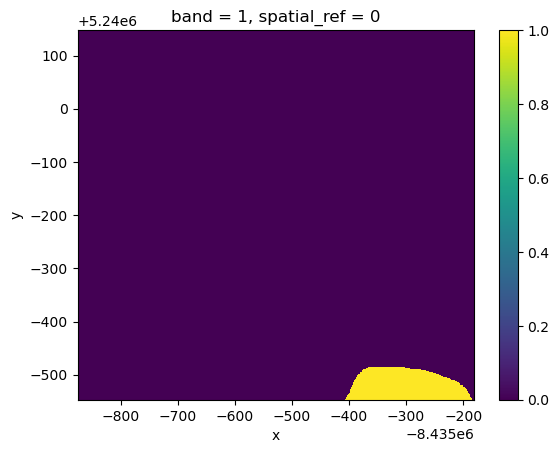

In [64]:
test = geoai.read_raster("NWI/labels/tile_000257.tif")
test.plot()

In [65]:
f"{out_folder}/images"

'NWI/images'

In [67]:
geoai.train_MaskRCNN_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/models",
    num_channels=4,
    pretrained=True,
    batch_size=4,
    num_epochs=5,
    learning_rate=0.005,
    val_split=0.2,
)

Using device: cpu
Found 860 image files and 860 label files
Training on 688 images, validating on 172 images
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/Anthony/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|████████████████████████████████████████| 170M/170M [00:03<00:00, 56.9MB/s]


Epoch: 0, Batch: 0/172, Loss: 6.0916, Time: 21.93s
Epoch: 0, Batch: 10/172, Loss: nan, Time: 93.56s
Epoch: 0, Batch: 20/172, Loss: nan, Time: 92.21s
Epoch: 0, Batch: 30/172, Loss: nan, Time: 92.05s
Epoch: 0, Batch: 40/172, Loss: nan, Time: 96.44s
Epoch: 0, Batch: 50/172, Loss: nan, Time: 93.72s
Epoch: 0, Batch: 60/172, Loss: nan, Time: 92.67s
Epoch: 0, Batch: 70/172, Loss: nan, Time: 93.36s
Epoch: 0, Batch: 80/172, Loss: nan, Time: 93.18s
Epoch: 0, Batch: 90/172, Loss: nan, Time: 92.22s
Epoch: 0, Batch: 100/172, Loss: nan, Time: 91.91s
Epoch: 0, Batch: 110/172, Loss: nan, Time: 92.32s
Epoch: 0, Batch: 120/172, Loss: nan, Time: 92.03s
Epoch: 0, Batch: 130/172, Loss: nan, Time: 91.93s
Epoch: 0, Batch: 140/172, Loss: nan, Time: 92.02s
Epoch: 0, Batch: 150/172, Loss: nan, Time: 92.59s
Epoch: 0, Batch: 160/172, Loss: nan, Time: 92.53s
Epoch: 0, Batch: 170/172, Loss: nan, Time: 92.22s
Epoch 1/5: Train Loss: nan, Val Loss: inf, Val IoU: 0.0000
Epoch: 1, Batch: 0/172, Loss: nan, Time: 17.87s
E

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x30cd50fe0>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/geo_ai/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/opt/miniconda3/envs/geo_ai/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/miniconda3/envs/geo_ai/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/geo_ai/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/geo_ai/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/min

KeyboardInterrupt: 